# **English To Italian - Machine Translation**

# **Dependancies :**

In [1]:
# Importing dependancies

import os
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from IPython.display import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense
from tensorflow.keras.models import Model, save_model

# **Configuration :**

In [2]:
# Setting to use seaborn style for plots
matplotlib.style.use("seaborn")

# Suppress warnings
warnings.filterwarnings("ignore")

<ipython-input-2-e9aa3efcb9b4>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn")


# **Loading data and basic preprocessing :**

In [3]:
# Download training set from : https://www.kaggle.com/datasets/balamurugan1603/nmtitalian2english
!unzip archive.zip

Archive:  archive.zip
  inflating: _about.txt              
  inflating: ita.txt                 


In [10]:
# Loads data
data = pd.read_csv("/content/ita.txt", sep="\t")

In [11]:
# Sets column names
data.columns = ["english", "italian", "attrib"]

In [12]:
data.drop(["attrib"], inplace=True, axis=1)

In [13]:
display(data.head())
display(data.info())

,english,italian
0,Hi.,Ciao.
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352039 entries, 0 to 352038
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  352039 non-null  object
 1   italian  352039 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


None

In [14]:
# Drops null values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352039 entries, 0 to 352038
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  352039 non-null  object
 1   italian  352039 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


In [15]:
# Adds 'sos' and 'eos' to start and end of target (Italian) text
# 'sos' --> Denotes start of sequence; 'eos' --> Denotes end of sequence

data["italian"] = data["italian"].apply(lambda x: "sos " + x + " eos")

# **Splitting Data :**

In [16]:
# Train data: 60%; Validation data: 20%; Test data: 10000 sentences;
eng_train, eng_remaining, it_train, it_remaining  = train_test_split(data["english"].values, 
                                                                     data["italian"].values, 
                                                                     test_size=0.4, 
                                                                     random_state=22)

eng_val, eng_test, it_val, it_test = train_test_split(eng_remaining, 
                                                      it_remaining, 
                                                      test_size=0.5, 
                                                      random_state=22)

# Taking 10k sentences as test set
eng_test = eng_test[:10000]
it_test = it_test[:10000]

In [17]:
print(len(eng_train))
print(len(eng_val))
print(len(eng_test))

211223
70408
10000


In [18]:
print(eng_train[:5])
print(eng_val[:5])
print(eng_test[:5])
print(it_train[:5])
print(it_val[:5])
print(it_test[:5])

['Tom wants to work.' "Tom is quite conservative, isn't he?"
 'There are teachers and then there are teachers.'
 "You love children, don't you?" 'This car is worthless.']
["I know that Tom wasn't a popular kid at his school."
 'My car needs washing.' "We'll be there." 'So what do you want to know?'
 'Why did you go there?']
["That's serious." 'Tom is teaching me how to swim.'
 'Are you sure this thing is safe?' 'They were so happy together.'
 'Both Tom and I were shocked.']
['sos Tom vuole lavorare. eos'
 'sos Tom è piuttosto conservatore, vero? eos'
 'sos Ci sono insegnanti e insegnanti. eos' 'sos Ama i bambini, vero? eos'
 'sos Questa auto è inutile. eos']
['sos So che Tom non era un bambino popolare nella sua scuola. eos'
 'sos La mia automobile ha bisogno di essere lavata. eos'
 'sos Noi saremo lì. eos' 'sos Quindi che cosa vuole sapere? eos'
 'sos Perché è andata lì? eos']
['sos È serio. eos' 'sos Tom mi sta insegnando a nuotare. eos'
 'sos Siete sicure che questa cosa sia sicura?

# **Fitting tokenizer and defining preprocessing functions :**

In [20]:
# Instantiating and fitting the Tokenizer on english text
eng_tokenizer_train_data = data["english"]
eng_tok = Tokenizer(oov_token="UNK")
eng_tok.fit_on_texts(eng_tokenizer_train_data.values)

# Instantiating and fitting the Tokenizer on italian text
it_tokenizer_train_data = data["italian"]
it_tok = Tokenizer(oov_token="UNK")
it_tok.fit_on_texts(it_tokenizer_train_data.values)

In [21]:
def sent_to_seq(sequences, tokenizer, vocab_size=None, reverse=False, onehot=False):
    
    """ Converts text data into sequences supported by model input layers.
    
    Args:
        sequences (list): List of text data.
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tensorflow tokenizer object.
        vocab_size (int): Number of words in the whole vocabulary.
        reverse (bool): Reverses the padded sequence if set True. Defaults False.
                        (Eg: if set True, [1 2 3 0 0] becomes [0 0 3 2 1])
        onehot (bool): Creates onehot representation of the padded sequence if set True.
                       Defaults False.
                       
    Returns:
        preprocessed_seq (list): List of preprocessed sequences.
        
    """
    
    # Tokenizing
    seq = tokenizer.texts_to_sequences(sequences)
    
    # Padding
    preprocessed_seq = pad_sequences(seq, padding='post', truncating='post', maxlen=20)
    
    # Reversing
    if reverse:
        preprocessed_seq = preprocessed_seq[:, ::-1]
    
    # Onehot encoding
    if onehot:
        preprocessed_seq = to_categorical(preprocessed_seq, num_classes=vocab_size) 
    
    return preprocessed_seq


In [22]:
def generate_batch(X, y, batch_size):
    
    """ Generator function to preprocess the data in batches and
        feed them to the model.
        
    Args:
        X (list): List of text data.
        y (list): List of text data.
        batch_size (int): Number of items to be preprocessed and fed
                          in a single batch.
    Yields:
        en_x (list): Preprocessed data supported by encoder input layer.
        de_x (list): Preprocessed data supported by decoder input layer.
                    (1 timestep behind de_y, since 
                     TimeDistributed layer is being used for training)
        de_y (list): Preprocessed actual outputs of decoder. 
                     (1 timestep ahead of de_x, since 
                     TimeDistributed layer is being used for training)
    """
    
    while True:   
        for batch in range(0, len(X), batch_size):
            en_x = sent_to_seq(X[batch: batch+batch_size], 
                               tokenizer = eng_tok, 
                               vocab_size = eng_vocab_size,
                               onehot = True, 
                               reverse = True)

            de_xy = sent_to_seq(y[batch: batch+batch_size],
                                tokenizer = it_tok,
                                vocab_size = it_vocab_size,
                                onehot = True)

            de_x = de_xy[:,:-1,:]
            de_y = de_xy[:,1:,:]

            yield([en_x, de_x], de_y)

# **Defining Model Architecture :**

In [23]:
eng_seq_len = 20    # First dimension of encoder Input shape
eng_vocab_size = len(eng_tok.word_index)+1    # Second dimension of encoder Input shape
gru_units = 2048    # Number of GRU units

In [24]:
# Encoder  
en_inputs = Input(shape=(eng_seq_len, eng_vocab_size)) 
en_gru = GRU(gru_units, return_state=True) 
en_out, en_state = en_gru(en_inputs)

In [25]:
it_seq_len = 20     # First dimension of decoder Input shape
it_vocab_size = len(it_tok.word_index)+1     # Second dimension of decoder Input shape

In [28]:
# Decoder
de_inputs = Input(shape=(it_seq_len-1, it_vocab_size))
de_gru = GRU(gru_units, return_sequences=True)
de_out = de_gru(de_inputs, initial_state=en_state)

In [29]:
# Decoder output architecture
# TimeDistributed layer is used for training purpose
de_dense = TimeDistributed(Dense(it_vocab_size, activation='softmax'))    
de_pred = de_dense(de_out)

In [30]:
# Compiling
nmt = Model(inputs=[en_inputs, de_inputs], outputs=de_pred) 
nmt.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["acc"])

In [ ]:
print(nmt.summary())

# **Training, Evaluating and plotting results :**

In [ ]:
def plot_history(history, metric = "loss"):
    
    """ Plots training history of models.
    
    Args:
        history (History): Tensorflow History object containing training 
                           history of the model.
        metric (str): 'accuracy' or 'loss'. Metric to be plotted. 
                           
    Returns:
        Nothing
        
    """
    
    history_dict = history.history
    epochs = range(1, len(history_dict['loss'])+1)
    
    if metric == "loss":
        train_loss = history_dict['loss']    # Training loss over epochs
        val_loss = history_dict['val_loss']    # Validation loss over epochs
        plt.plot(epochs, train_loss,'b', label='Training error')
        plt.plot(epochs, val_loss,'b', color="orange", label='Validation error')
        plt.title('Training and Validation error')
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()
        plt.show()
    
    elif metric == "accuracy":
        train_acc = history_dict['acc']    # Training accuracy over epochs
        val_acc = history_dict['val_acc']    # Validation accuracy over epochs
        plt.plot(epochs, train_acc,'b', label='Training accuracy')
        plt.plot(epochs, val_acc,'b', color="orange", label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    
    

In [ ]:
n_epochs, batch_size = 10, 64

In [ ]:
# Training and validation
history = nmt.fit(generate_batch(eng_train, it_train, batch_size=batch_size),
                  steps_per_epoch = len(eng_train)//batch_size,
                  epochs = n_epochs,
                  validation_data = generate_batch(eng_val, it_val, batch_size=batch_size),
                  validation_steps = len(eng_val)//batch_size)

2021-10-07 04:42:24.145037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 04:42:24.149341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/10


2021-10-07 04:42:26.383459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-07 04:42:27.316467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-07 04:42:27.478572: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


3300/3300 [==============================] - 2650s 801ms/step - loss: 1.8352 - acc: 0.7431 - val_loss: 1.0887 - val_acc: 0.8027
Epoch 2/10
3300/3300 [==============================] - 2648s 803ms/step - loss: 0.9890 - acc: 0.8123 - val_loss: 0.8416 - val_acc: 0.8363
Epoch 3/10
3300/3300 [==============================] - 2659s 806ms/step - loss: 0.6929 - acc: 0.8515 - val_loss: 0.7119 - val_acc: 0.8579
Epoch 4/10
3300/3300 [==============================] - 2652s 804ms/step - loss: 0.4978 - acc: 0.8824 - val_loss: 0.6632 - val_acc: 0.8679
Epoch 5/10
3300/3300 [==============================] - 2657s 805ms/step - loss: 0.3771 - acc: 0.9056 - val_loss: 0.6505 - val_acc: 0.8720
Epoch 6/10
3300/3300 [==============================] - 2662s 807ms/step - loss: 0.3074 - acc: 0.9211 - val_loss: 0.6647 - val_acc: 0.8731
Epoch 7/10
3300/3300 [==============================] - 2666s 808ms/step - loss: 0.2658 - acc: 0.9312 - val_loss: 0.6679 - val_acc: 0.8738
Epoch 8/10
3300/3300 [================

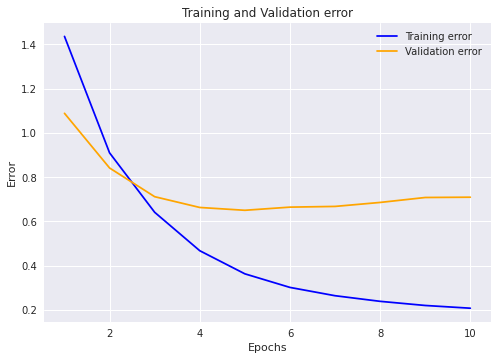

In [ ]:
plot_history(history)

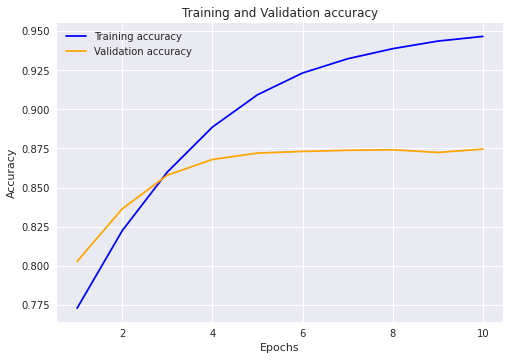

In [ ]:
plot_history(history, metric="accuracy")

In [ ]:
# Evaluating on completely unseen data
results = nmt.evaluate(generate_batch(eng_test, it_test, batch_size=batch_size), steps=batch_size)
print(f"========== Test set loss: {results[0]} - Test set Accuracy: {results[1]*100} % ==========")

64/64 [==============================] - 33s 512ms/step - loss: 0.6971 - acc: 0.8757
========== Test set loss: 0.6970807909965515 - Test set Accuracy: 87.5732421875 % ==========


# **Copying trained layers' weights :**

In [ ]:
en_gru_weights = en_gru.get_weights()   # Encoder GRU layer weights
de_gru_weights = de_gru.get_weights()    # Decoder GRU layer weights
de_dense_weights = de_dense.get_weights()    # Decoder Dense layer weights

# **Defining inference model Architecture :**

In [ ]:
# Encoder
en_inputs = Input(shape=(eng_seq_len, eng_vocab_size)) 
en_gru = GRU(gru_units, return_state=True) 
en_out, en_state = en_gru(en_inputs)

encoder = Model(inputs=en_inputs, outputs=en_state)

In [ ]:
# Assigns weights of trained model layer to inference model layer 
en_gru.set_weights(en_gru_weights)

In [ ]:
# Decoder
de_inputs = Input(shape=(1, it_vocab_size))

# Following layer is added in inference model
# to take context vector as input
de_state_in = Input(shape=(gru_units,))     

de_gru = GRU(gru_units, return_state=True) 
de_out, de_state_out = de_gru(de_inputs, initial_state=de_state_in) 

# TimeDistributed layer is not used since
# we will be using .predict() method for
# each timestep manually
de_dense = Dense(it_vocab_size, activation='softmax') 
de_pred = de_dense(de_out)

decoder = Model(inputs=[de_inputs, de_state_in], outputs=[de_pred, de_state_out]) 

In [ ]:
# Assigns weights of trained model layers to inference model layers 
de_gru.set_weights(de_gru_weights)
de_dense.set_weights(de_dense_weights)

In [ ]:
print(decoder.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 28445)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, 2048), (None 187361280   input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 28445)        58283805    gru_3[0][0]                

# **Translation in action :**

In [ ]:
def word_to_onehot(tokenizer, word, vocab_size):
    
    de_seq = tokenizer.texts_to_sequences([[word]])
    de_onehot = to_categorical(de_seq, num_classes=vocab_size).reshape(1, 1, vocab_size)  
    
    return de_onehot


def translate(eng_sentence):
    
    en_seq = sent_to_seq([eng_sentence], 
                         tokenizer=eng_tok, 
                         reverse=True, 
                         onehot=True, 
                         vocab_size=eng_vocab_size)
    
    en_st = encoder.predict(en_seq)
    de_seq = word_to_onehot(it_tok, "sos", it_vocab_size)
    it_sent = ""
    for i in range(it_seq_len):         
        de_prob, en_st = decoder.predict([de_seq, en_st])
        index = np.argmax(de_prob[0, :], axis=-1)
        de_w = it_tok.index_word[index]
        de_seq = word_to_onehot(it_tok, de_w, it_vocab_size) 
        if de_w == 'eos': break
        it_sent += de_w + ' '
        
    return it_sent

In [ ]:
for sent in eng_test[: 25]:
    print(f"English: {sent}")
    print(f"Translated text: {translate(sent)}")

English: That's serious.
Translated text: è seria 
English: Tom is teaching me how to swim.
Translated text: tom mi sta disturbando 
English: Are you sure this thing is safe?
Translated text: siete sicure che questo sia sicuro 
English: They were so happy together.
Translated text: erano così felici assieme 
English: Both Tom and I were shocked.
Translated text: sia tom che mary erano sorpresi 
English: Anybody can use it.
Translated text: chiunque può farlo 
English: I encouraged Tom to learn French.
Translated text: io ho incoraggiato tom a imparare il francese 
English: I really like your paintings.
Translated text: mi piacciono veramente i tuoi dipinti 
English: This is the cheapest shop in town.
Translated text: questo è il libro che voglio leggere 
English: Have you ever had this problem before?
Translated text: ha mai avuto questo problema 
English: I usually drink coffee without sugar.
Translated text: io bevo del caffè al mattino 
English: Tom won't like it.
Translated text: t